In [1]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt





In [3]:
# Чтение данных
df = pd.read_pickle('random_sample_200k.pickle')
texts = df['text'].tolist()  # Предполагается, что колонка с текстовыми описаниями называется 'описание_товара'


In [4]:
df

,text,new_code
4004427,Термостат суховоздушный ТВ-80-1,33
4551450,Услуги по холодному водоснабжению,36
6579286,СС КонсультантСудебнаяПрактика: Суды Москвы и ...,62
1028808,Короб архивный на завязках № 1,17
2281960,Степлер,25
...,...,...
5634519,Щетка каркасная 380мм,45
7234495,Поиск нового владельца одному животному без вл...,75
7417117,Пульт контроля и управления «С2000-М»,80
2974838,Фотобарабан DL-420 совместимый,28


In [5]:
labels = df['new_code'].tolist()

In [6]:
# Подготовка данных для Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(texts)]

In [9]:
# Обучение модели Doc2Vec
import time
start_time = time.time()

model = Doc2Vec(documents, vector_size=96, min_count=2, workers=4)
print("--- %s seconds ---" % (time.time() - start_time))

--- 138.80943965911865 seconds ---


In [10]:
# Получение векторов для документов
start_time = time.time()
vectors = [model.infer_vector(doc.words) for doc in documents]
print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
vectors

[array([ 0.00022514, -0.03641265, -0.00982627,  0.01379165,  0.00417965,
        -0.009963  , -0.028019  , -0.00390421, -0.02986878,  0.00308785,
         0.01228973, -0.00542317, -0.01631127, -0.01359741, -0.01135404,
         0.0170191 , -0.00567698,  0.02185545,  0.00173751,  0.02041586,
         0.04311764,  0.0015133 ,  0.02749612,  0.00189116, -0.00138772,
        -0.01436131, -0.02413261, -0.00976552, -0.01642083, -0.00724093,
         0.00666355, -0.01073271,  0.01872732, -0.00258645,  0.00011945,
         0.01385674,  0.01300961, -0.00259263, -0.00192928,  0.03439155,
        -0.01597517, -0.03002851,  0.00828967, -0.01200527, -0.01709728,
         0.02940194,  0.03973824,  0.01736192, -0.01699349, -0.00294162,
         0.0011044 , -0.00095645,  0.013828  ,  0.02325608, -0.00222746,
        -0.02494985,  0.01607301,  0.04231123, -0.02009608,  0.02100488,
        -0.01622707, -0.0207947 ,  0.00538692,  0.01063718,  0.01060049,
        -0.05212107, -0.01359618, -0.01874846, -0.0

In [12]:
start_time = time.time()
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42)

# Обучение логистической регрессии
log_reg = LogisticRegression(max_iter=2000, multi_class='ovr', solver ='newton-cg' )
log_reg.fit(X_train, y_train)

# Предсказания модели
y_scores = log_reg.predict_proba(X_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 214.43671941757202 seconds ---


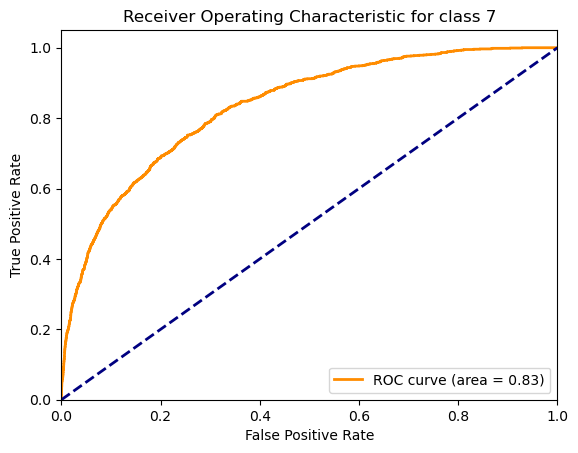

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Бинаризация меток для многоклассовой классификации
y_test_binarized = label_binarize(y_test, classes=np.unique(labels))

# Предсказание вероятностей для всех классов
y_score = log_reg.predict_proba(X_test)

# Вычисление ROC AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_binarized.shape[1]-1):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i-1], y_score[:, i-1])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для первого класса
plt.figure()
class_number =7
plt.plot(fpr[class_number], tpr[class_number], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[class_number])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for class 7')
plt.legend(loc="lower right")
plt.show()


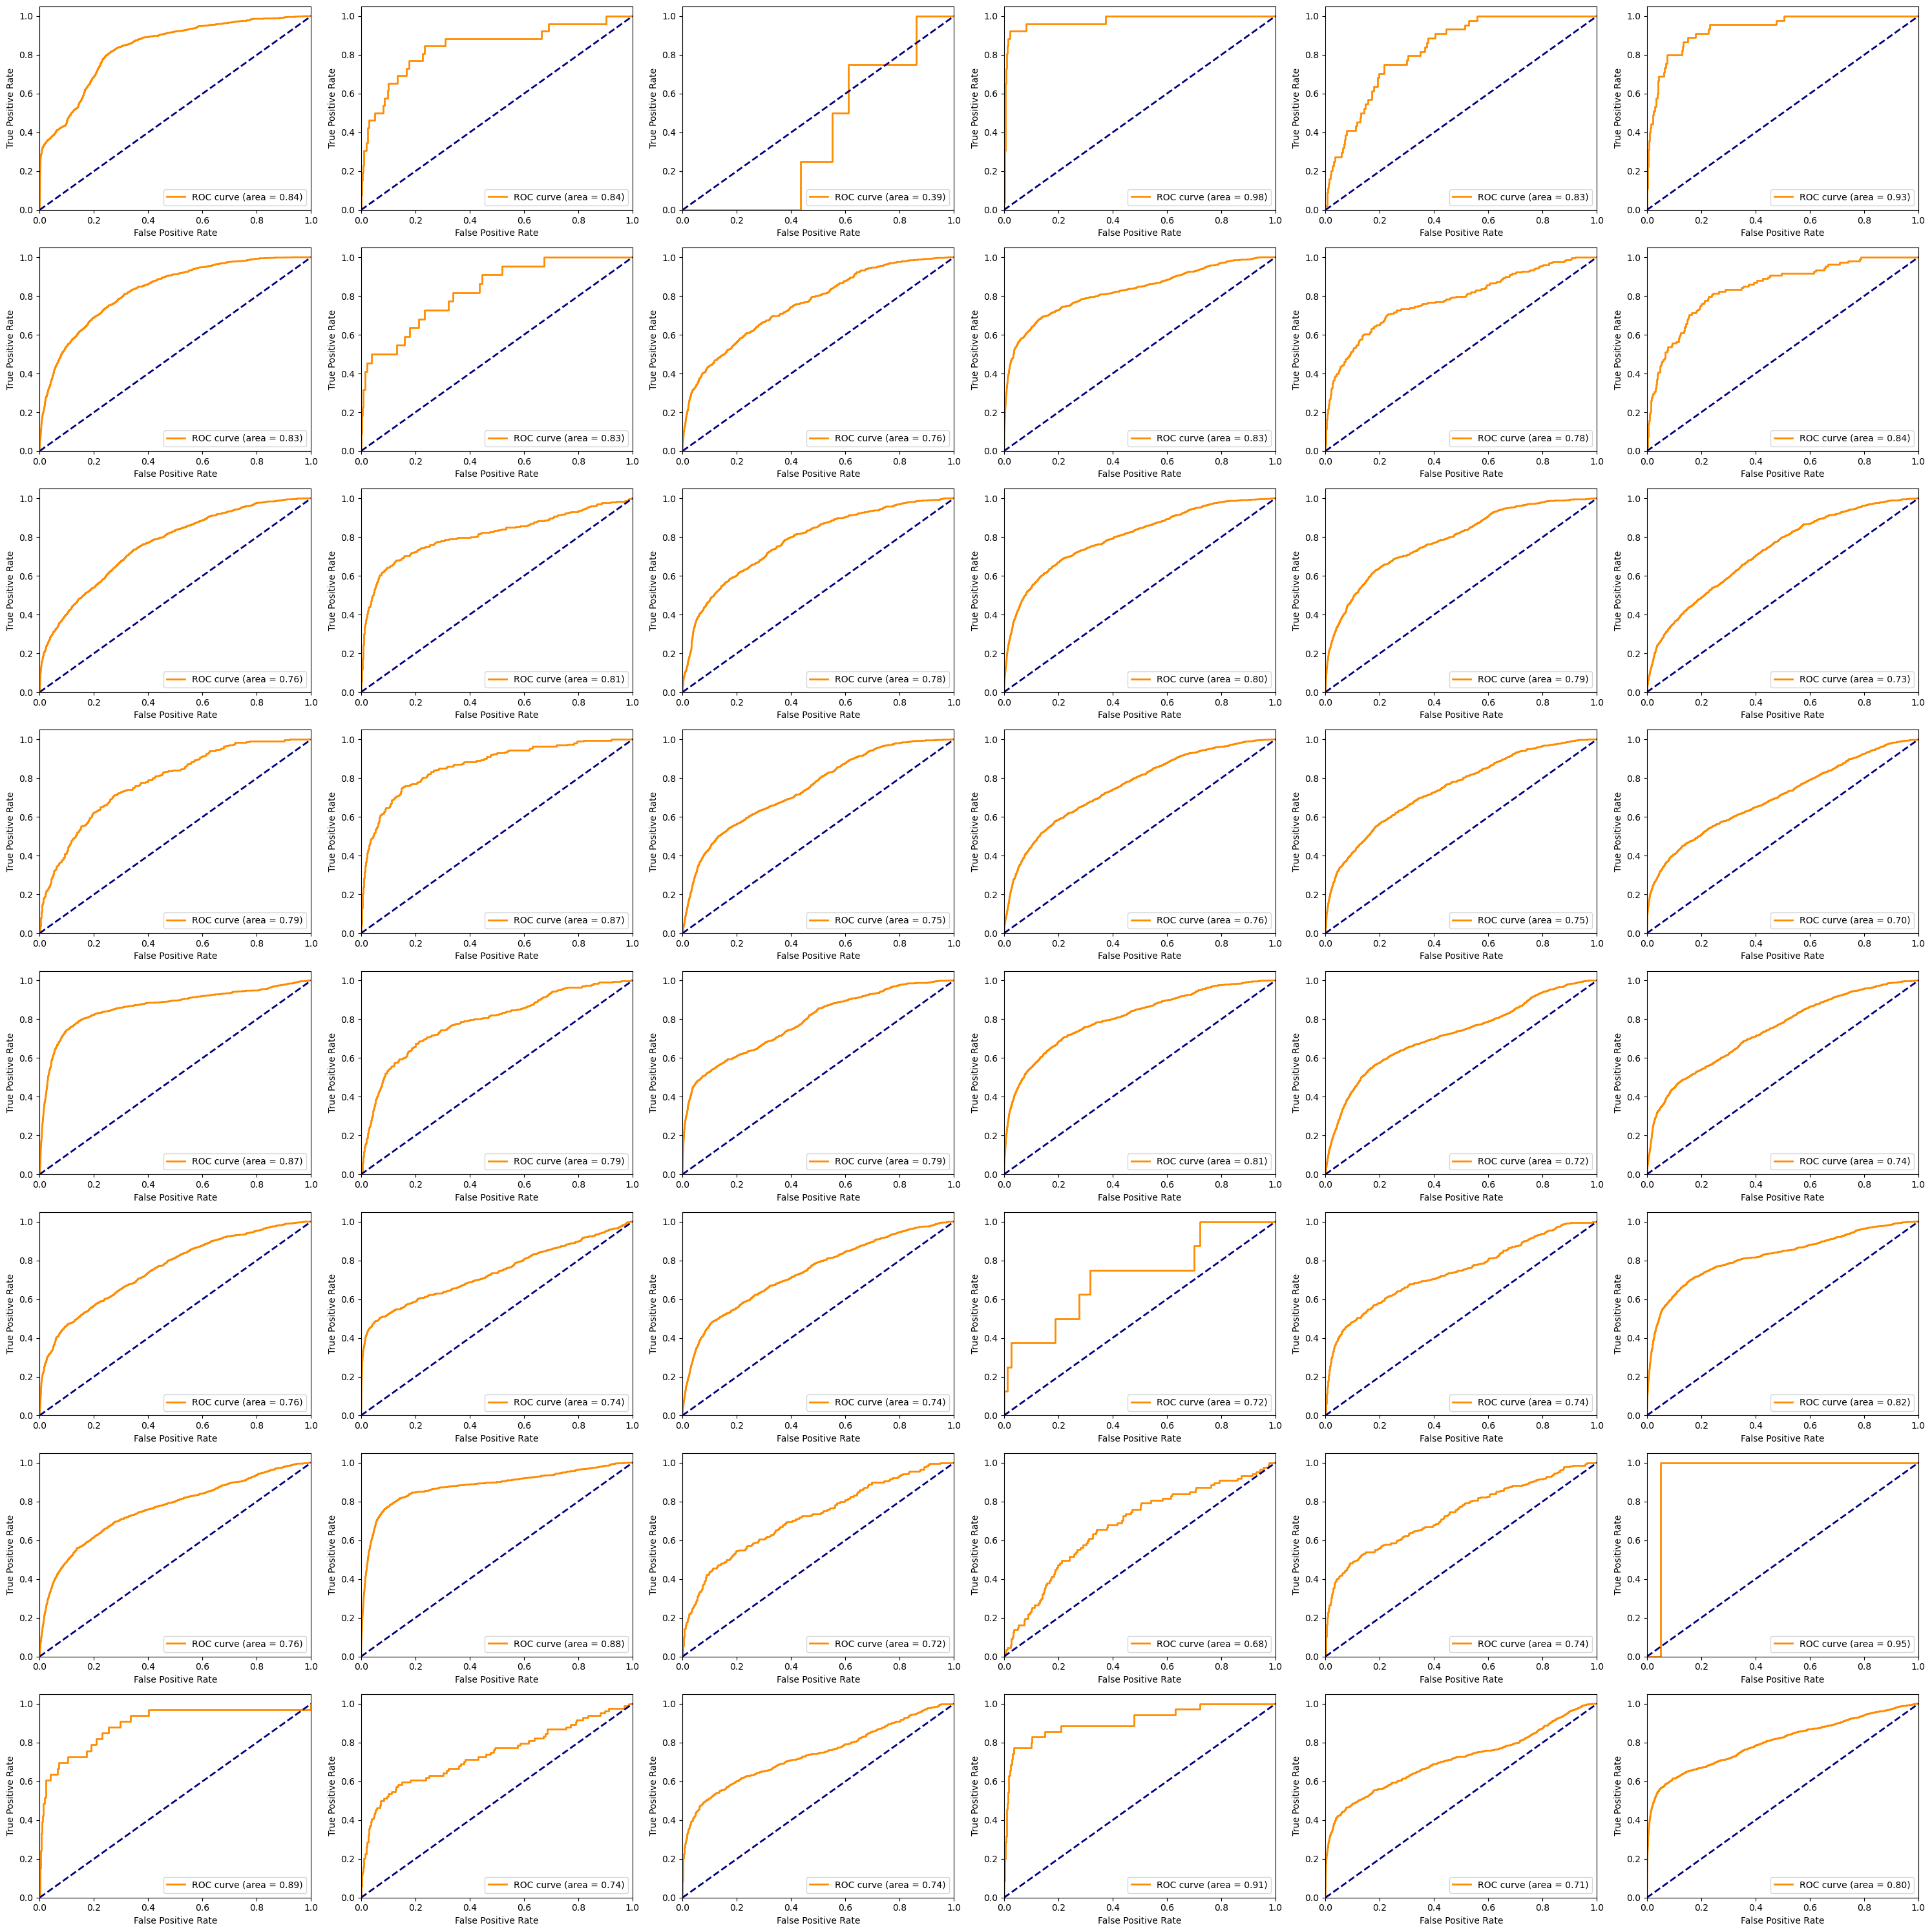

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Предполагается, что y_test_binarized и y_score уже вычислены
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 48

# Вычисление ROC AUC для каждого класса
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Создание фигуры для подграфиков
fig, axes = plt.subplots(8, 6, figsize=(30, 30))  # Размер фигуры можно настроить
axes = axes.ravel()  # Преобразование матрицы осей в плоский массив

for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    #axes[i].set_title(f'Receiver Operating Characteristic for class {i}')
    axes[i].legend(loc="lower right")

plt.tight_layout()  # Автоматическая корректировка подграфиков для предотвращения наложения
plt.show()


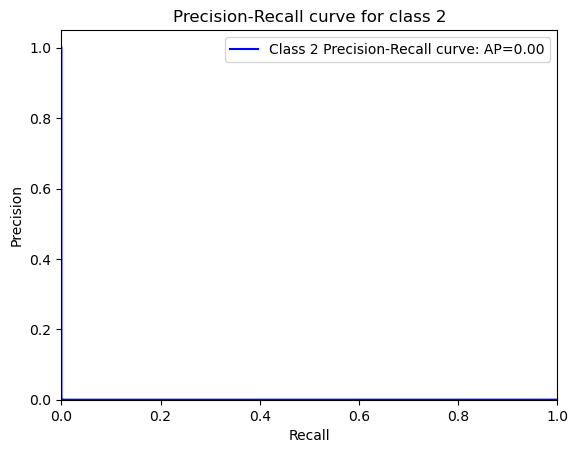

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Инициализация словарей
precision = dict()
recall = dict()
average_precision = dict()

# Вычисление Precision и Recall для каждого класса
for i in range(y_test_binarized.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_score[:, i])

# Выбор номера класса для визуализации
class_number = 2

# Построение графика Precision-Recall
plt.figure()
plt.step(recall[class_number], precision[class_number], where='post', color='blue', label='Class %d Precision-Recall curve: AP=%0.2f' % (class_number, average_precision[class_number]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for class %d' % class_number)
plt.legend(loc="upper right")
plt.show()


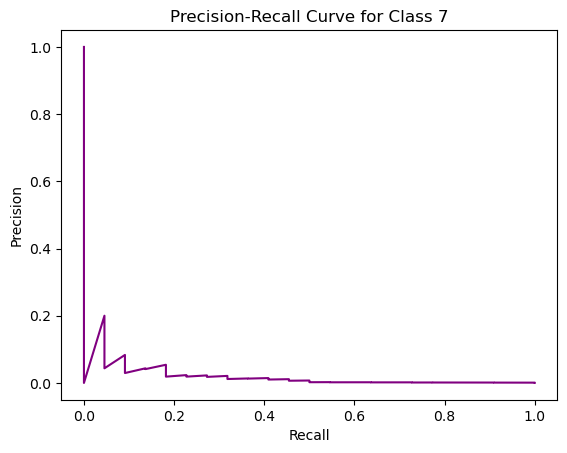

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Выбор индекса для интересующего класса
class_index = 7  # Измените на индекс вашего класса

# Вычисление Precision и Recall для конкретного класса
precision, recall, thresholds = precision_recall_curve(y_test_binarized[:, class_index], y_score[:, class_index])

# Создание графика Precision-Recall
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

# Добавление названий осей к графику
ax.set_title('Precision-Recall Curve for Class %d' % class_index)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

# Отображение графика
plt.show()


**Качество результатов заметно хуже по сравнению с экспериментами с моделью spaCy**